# SINE WAVE MODEL
This script is to develop a model to predict the sine of a value. The model is deployed to a stm32 board (nucleo-l476rg). The model is converted to a tflite model to be run with the tensorflowlite-micro tflm frame work.

## Importing the needed library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-05-23 20:00:40.813055: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 20:00:40.813779: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 20:00:40.817437: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 20:00:40.828384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748026840.845562   29357 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748026840.85

## Defining Necessary Constants

In [2]:
SAMPLE_SIZE = 1_000
RANDOM_SEED = 25
PI = 3.14159265359

MODEL_FILE_NAME = "SINE_MODEL"
C_HEADER_DIR = "../deployment/include/"

train_ratio = .7
test_ratio = .2
validation_ratio = .1

## Generating the dataset
The data will contain numbers between 0 and 2pi, the sine function will be defined in rad.
A random uniform error is added to the sine values to give the dataset a bit of variability and see how the model will perform.
The error is centred with a mean of 0 and std 0f 0.1. This is chosen such that 95% of the error is -0.2 and 0.+2.

In [3]:
np.random.seed(RANDOM_SEED) # for reproduction
tf.random.set_seed(RANDOM_SEED)
 
x = np.random.uniform(low=0, high=2*PI, size=SAMPLE_SIZE)
y = np.sin(x) + np.random.normal(0, 0.1, size=SAMPLE_SIZE)
x.shape, y.shape

((1000,), (1000,))

### Plot of the data
1. The distribution of the imput data.
2. The relationship between the output y and x i.e. the sine curve.

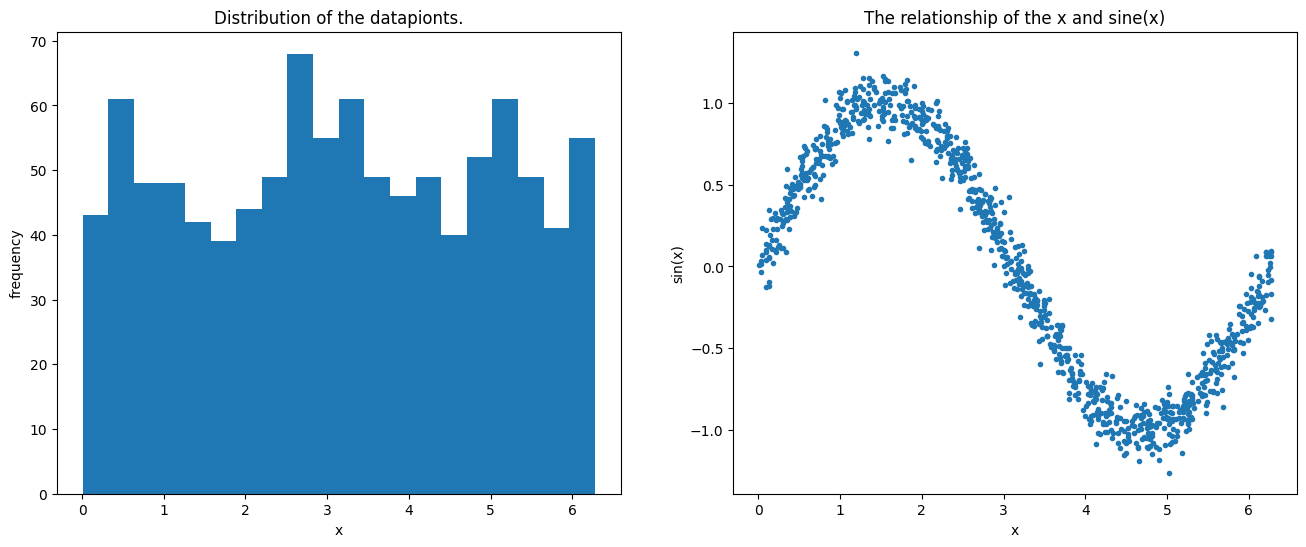

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].hist(x, bins=20)
axes[0].set_title("Distribution of the datapionts.")
axes[0].set_xlabel("x")
axes[0].set_ylabel("frequency")

axes[1].scatter(x,y, marker=".")
axes[1].set_title("The relationship of the x and sine(x)")
axes[1].set_ylabel("sin(x)")
axes[1].set_xlabel("x")

plt.show()

## Preparing the data for training

In [5]:
# x_train = x[:SAMPLE_SIZE * train_ratio]
# y_train = y[:SAMPLE_SIZE * train_ratio]

# x_test = x[SAMPLE_SIZE * train_ratio : SAMPLE_SIZE * test_ratio]
# y_test = y[SAMPLE_SIZE * train_ratio : SAMPLE_SIZE * test_ratio]

# x_validate = x[SAMPLE_SIZE * (1 - validation_ratio):]
# y_validate = y[SAMPLE_SIZE * (1 - validation_ratio):]

x_train, x_test, x_validate = np.split(x, [int(train_ratio*SAMPLE_SIZE), int((train_ratio+test_ratio)*SAMPLE_SIZE)])
y_train, y_test, y_validate = np.split(y, [int(train_ratio*SAMPLE_SIZE), int((train_ratio+test_ratio)*SAMPLE_SIZE)])

### Make a plot to show to distribution of the training, testing and validation data.

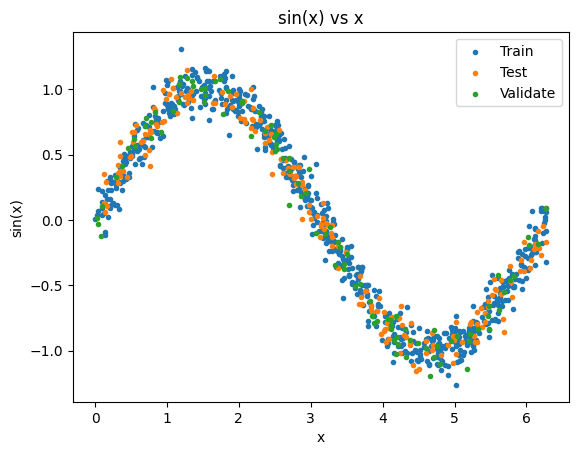

In [6]:
plt.scatter(x_train, y_train,marker=".", label="Train")
plt.scatter(x_test, y_test, marker=".", label="Test")
plt.scatter(x_validate, y_validate, marker=".", label="Validate")

plt.title("sin(x) vs x")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.legend()
plt.show()

## Model Definition
A simple  model will be used to test the framework. A 2 [hidden] layer model with the following:
- Input layer -> 1 neuron
- Hidden layer 1 -> 32 neurons
- Hidden layer 2 -> 16 neurons
- Output layer -> 1 neuron

In [7]:
sine_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(1,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

/home/matthias/Documents/EmbeddedAI/stm32-tinyml-sine/development/tf_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1748026843.052664   29357 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748026843.053096   29357 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
sine_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
sine_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = sine_model.fit(x_train, y_train, batch_size=100, epochs=1000, validation_data=(x_validate, y_validate))

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0282 - mae: 0.8635 - val_loss: 0.5771 - val_mae: 0.6873
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4718 - mae: 0.6040 - val_loss: 0.4862 - val_mae: 0.5869
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4457 - mae: 0.5563 - val_loss: 0.4862 - val_mae: 0.5779
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4308 - mae: 0.5473 - val_loss: 0.4392 - val_mae: 0.5678
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3781 - mae: 0.5250 - val_loss: 0.4264 - val_mae: 0.5780
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3626 - mae: 0.5211 - val_loss: 0.4050 - val_mae: 0.5631
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3416 - mae: 0.5037 - val_loss: 0.3783 - val_mae: 0.5387
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3214 - mae: 0.4864 - val_loss: 0.3592 - val_mae: 0.5253
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.305

## Training Plot

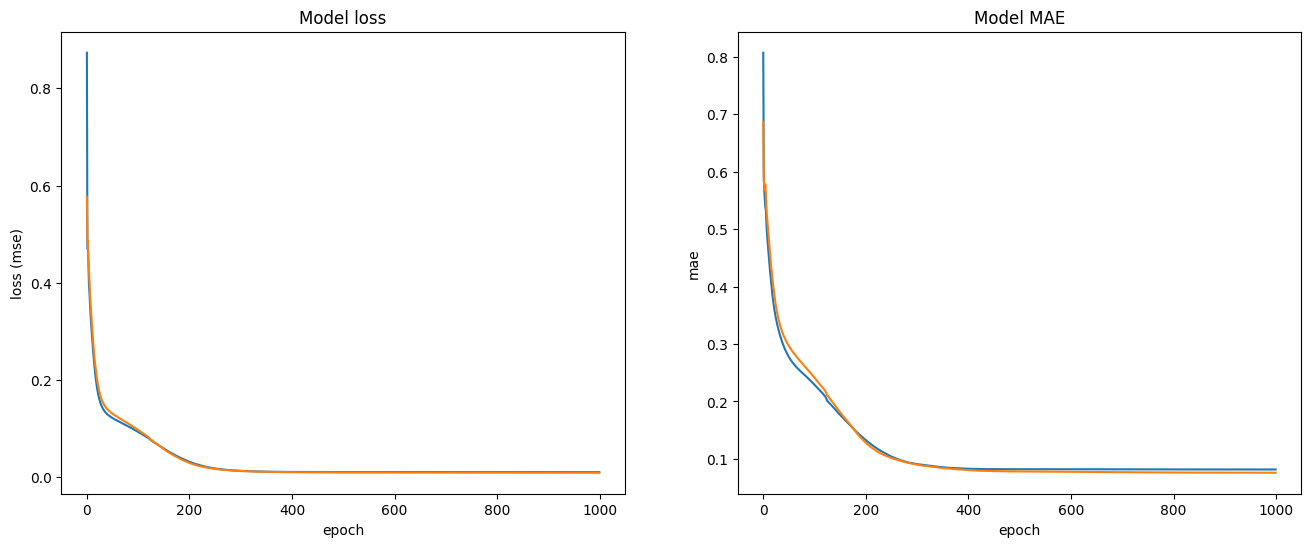

In [10]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6))

axes[0].plot(history.history["loss"], label="training_loss")
axes[0].plot(history.history["val_loss"], label="validation_loss")
axes[0].set_title("Model loss")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss (mse)")

axes[1].plot(history.history["mae"], label="training_mae")
axes[1].plot(history.history["val_mae"], label="validation_loss")
axes[1].set_title("Model MAE")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("mae")

plt.show()

## Testing the model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


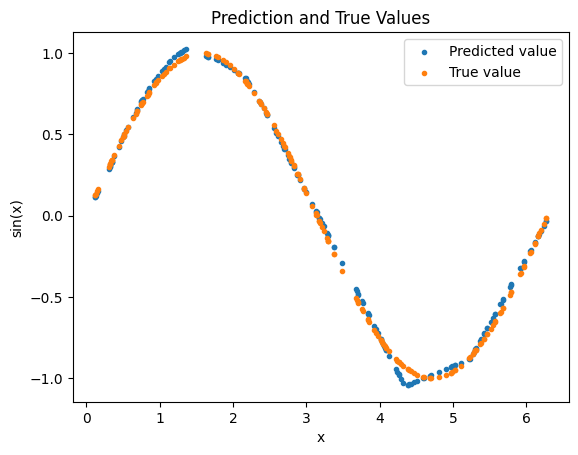

In [11]:
y_test_predict = sine_model.predict(x_test)
y_test_true = np.sin(x_test)

plt.scatter(x_test, y_test_predict, marker=".", label="Predicted value")
plt.scatter(x_test, y_test_true, marker=".", label="True value")
plt.title("Prediction and True Values")
plt.ylabel("sin(x)")
plt.xlabel("x")
plt.legend()
plt.show()

## Saving the keras model

In [12]:
sine_model.save("sine_model.keras")

## Converting the model to tflite

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(sine_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
sine_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp3nb8xip2/assets


INFO:tensorflow:Assets written to: /tmp/tmp3nb8xip2/assets


Saved artifact at '/tmp/tmp3nb8xip2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132831228279504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132831228280272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132831228278352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132831228277776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132831228277968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132831228279312: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1748026967.718978   29357 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748026967.719022   29357 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-23 20:02:47.720115: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3nb8xip2
2025-05-23 20:02:47.721336: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-23 20:02:47.721356: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp3nb8xip2
I0000 00:00:1748026967.728831   29357 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-05-23 20:02:47.730249: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-23 20:02:47.760687: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp3nb8xip2
2025-05-23 20:02:47.768398: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

## Converting the model to the c, TFlite micro format for the microcontroller

In [17]:
# Breaking the byte in several lines to fit better in the c header file
sine_tflite_model_split_line = np.array_split([format(hex_value, '#04x') for hex_value in sine_tflite_model], len(sine_tflite_model)//8)

# Write TfLite model to a C header file
open(f"{C_HEADER_DIR}{MODEL_FILE_NAME.lower()}.h", "w").write(
f"""
#ifndef {MODEL_FILE_NAME.upper()}_H
#define {MODEL_FILE_NAME.upper()}_H

const unsigned int {MODEL_FILE_NAME.lower()}_len = {len(sine_tflite_model)};

const unsigned char {MODEL_FILE_NAME.lower()}[{len(sine_tflite_model)}] = {{
    {",\n    ".join([", ".join(line) for line in sine_tflite_model_split_line])}
}};

#endif // {MODEL_FILE_NAME.upper()}_H
"""
)

# Saving the TfLite model
open(f"{MODEL_FILE_NAME}.tflite", "wb").write(sine_tflite_model)

4320

## Testing the converted tflite model

In [15]:
interpreter = tf.lite.Interpreter(model_path=f"{MODEL_FILE_NAME}.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

y_test_tflite_predict = []
for x_ in x_test:
  # Set input tensor
  interpreter.set_tensor(input_details[0]['index'], np.array([[x_]], dtype=np.float32))

  # Run the inference
  interpreter.invoke()

  y_test_tflite_predict.append(interpreter.get_tensor(output_details[0]['index']))

y_test_tflite_predict = np.array(y_test_tflite_predict)


/home/matthias/Documents/EmbeddedAI/stm32-tinyml-sine/development/tf_env/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


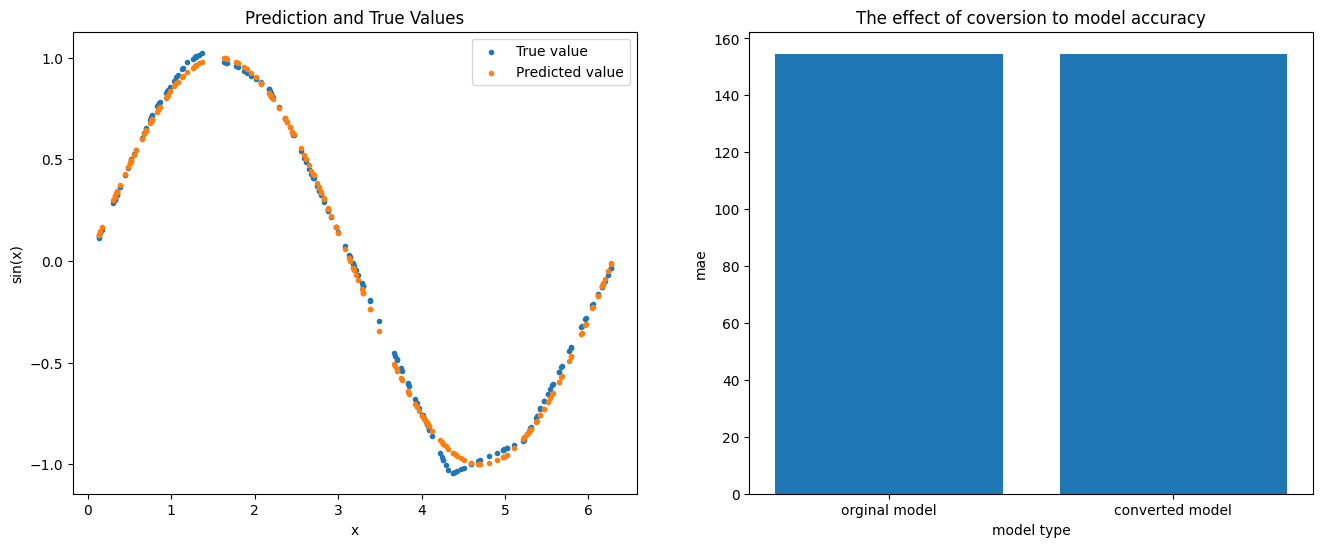

In [16]:
y_test_predict = sine_model.predict(x_test)
y_test_true = np.sin(x_test)

mae_orginal_model = np.sum(np.abs(y_test_predict - y_test)) / y_test.shape[0]
mae_converted_model = np.sum(np.abs(y_test_tflite_predict - y_test)) / y_test.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16,6))

axes[0].scatter(x_test, y_test_tflite_predict, marker=".", label="True value")
axes[0].scatter(x_test, y_test_true, marker=".", label="Predicted value")
axes[0].set_title("Prediction and True Values")
axes[0].set_ylabel("sin(x)")
axes[0].set_xlabel("x")
axes[0].legend()

axes[1].bar(["orginal model", "converted model"], [mae_orginal_model, mae_converted_model])
axes[1].set_title("The effect of coversion to model accuracy")
axes[1].set_ylabel("mae")
axes[1].set_xlabel("model type")

plt.show()